In [1]:
import os # Get the parent directory (project root)
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt

# import seaborn as sns
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)

from scripts.data_loader_and_featurizer import run_featurizer, data_path


Found local copy...
Loading...
Done!
100%|██████████| 404/404 [00:00<00:00, 4159.34it/s]


In [2]:
# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)



In [3]:
# run the featurization process using the Morgan fingerprint model for my
# datast split file and generates output files and saving them to `data_path`.

input_filenames = ["train_features.csv", "valid_features.csv", "test_features.csv"]
output_filenames = ["morgan_train_features.csv", "morgan_valid_features.csv", "morgan_test_features.csv"]
morgan_id = 'eos4wt0'
run_featurizer(model_id=morgan_id, input_filenames= input_filenames, output_filenames= output_filenames, data_path=data_path)

In [4]:
# run the featurization process using Compound Embeddings.
input_filenames = ["train_features.csv", "valid_features.csv", "test_features.csv"]
output_filenames = ["ComPEmbed_train_features.csv", "CompEmbed_valid_features.csv", "CompEmbed_test_features.csv"]
morgan_id = 'eos2gw4'
run_featurizer(model_id=morgan_id, input_filenames= input_filenames, output_filenames= output_filenames, data_path=data_path)

In [5]:
# Load the Morgan featureized & display first row to verify the data structure.
morgan_train_features_df = pd.read_csv(data_path/"morgan_train_features.csv")
morgan_train_features_df.head(1)

,key,input,fps-0,fps-1,fps-2,fps-3,fps-4,fps-5,fps-6,fps-7,...,fps-2038,fps-2039,fps-2040,fps-2041,fps-2042,fps-2043,fps-2044,fps-2045,fps-2046,fps-2047
0,BCMKFWFNEMRLOO-UHFFFAOYSA-N,CCOCc1cc(OC)c(B(O)O)c(OC)c1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### EDA: Doing some EDA for the original skin dataset from TDC.

In [6]:
# Load dataset and display 5 random samples

dataset = pd.read_csv(data_path/"skin_reaction.csv")
dataset.sample(5)

,Drug_ID,Drug,Y
53,4'-Methoxyacetophenone,COc1ccc(C(C)=O)cc1,0
214,Dipropylene triamine,NCCCNCCCN,1
199,Butyl acrylate,C=CC(=O)OCCCC,1
315,Abietic acid,CC(C)C1=CC2=CCC3C(C)(C(=O)O)CCCC3(C)C2CC1,1
232,Lauryl gallate,CCCCCCCCCCCCOC(=O)c1cc(O)c(O)c(O)c1,1


In [7]:
# printing data shape
"Shape of the dataset is {}.Contains {} rows and {} columns".format(dataset.shape,dataset.shape[0],dataset.shape[1])

'Shape of the dataset is (404, 3).Contains 404 rows and 3 columns'

Tabular summary of columns, non-null counts, and data types.: Our data has no null values 

In [8]:
pd.DataFrame({
    "Column": dataset.columns,
    "Non-Null Count": dataset.notnull().sum().values,
    "Dtype": dataset.dtypes.replace("object", "string").values # Show dtype object as string
})

,Column,Non-Null Count,Dtype
0,Drug_ID,404,string
1,Drug,404,string
2,Y,404,int64


**Data Uniqueness**: All our 404 rows are uniue molecules. There's no duplicates.

In [9]:
dataset.nunique().to_frame().rename(columns={0: 'Unique Values'})

,Unique Values
Drug_ID,404
Drug,404
Y,2


#### Class Balance:

The dataset is imbalanced, with the count of **skin sensitizers (class 1)** being twice as large as the count of **non-sensitizers (class 0)**. This skew towards the positive (sensitizers)class could bias model training, so techniques like resampling may be necessary.

In [10]:
value_counts = dataset['Y'].value_counts()
value_counts.to_frame()

,count
Y,
1,274
0,130


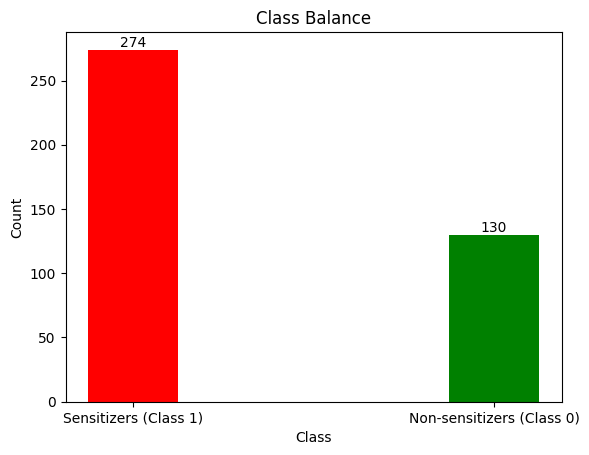

In [11]:
value_counts = dataset['Y'].value_counts()

# Define colors and labels dynamically based on the sorted order
class_mapping = {0: 'Non-sensitizers (Class 0)', 1: 'Sensitizers (Class 1)'}
colors = ['green' if idx == 0 else 'red' for idx in value_counts.index]
labels = [class_mapping[idx] for idx in value_counts.index]

# Create bar chart
bars = plt.bar(range(len(value_counts)), value_counts.values, color=colors, width=0.25)

# Add value labels on top of each bar>
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Set the x-axis labels
plt.xticks(range(len(value_counts)), labels)

# Set labels & title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Balance')

# Show plot
plt.show()


#### SMILES Length Analysis: Stats of complexity/size in `Drug` column:
- Most molecules are relatively small, hist peaking between 10–25 characters and a median length of 22. indicates simple structure.

- We have a right skewed distribution with a mean of 25 and a wide range of 4: 98, which highlights a long tail of complex molecules

- A standard deviation of 16 indicates significant variability relative to our 25 mean.

In [12]:
smiles_length = dataset['Drug'].str.len()
smiles_length.describe().to_frame().round(1)

,Drug
count,404.0
mean,25.4
std,15.9
min,4.0
25%,15.8
50%,22.0
75%,30.0
max,98.0


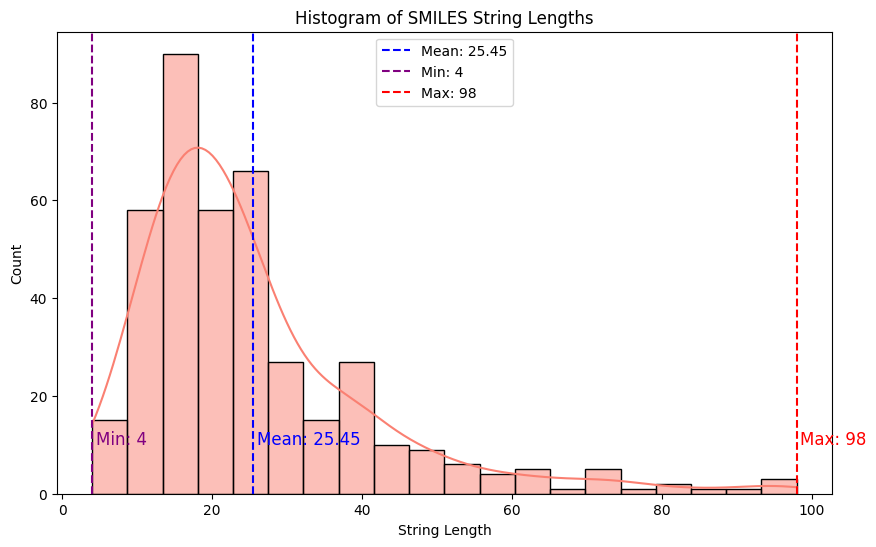

In [14]:
import seaborn as sns
# Calculate summary statistics
mean_length = smiles_length.mean()
std_dev = smiles_length.std()
min_length = smiles_length.min()
max_length = smiles_length.max()

# Create the histogram (show counts)
plt.figure(figsize=(10, 6))
sns.histplot(smiles_length, kde=True, bins=20, color='salmon', stat='count')

# Adding summary stats to the plot
plt.axvline(mean_length, color='blue', linestyle='--', label=f'Mean: {mean_length:.2f}')
plt.axvline(min_length, color='purple', linestyle='--', label=f'Min: {min_length}')
plt.axvline(max_length, color='red', linestyle='--', label=f'Max: {max_length}')

# Annotate the stats on the plot
plt.text(mean_length + 0.5, 10, f'Mean: {mean_length:.2f}', color='blue', fontsize=12)
plt.text(min_length + 0.5, 10, f'Min: {min_length}', color='purple', fontsize=12)
plt.text(max_length + 0.5, 10, f'Max: {max_length}', color='red', fontsize=12)

# Customize the plot labels and title
plt.title('Histogram of SMILES String Lengths')
plt.xlabel('String Length')
plt.ylabel('Count')

# Show the plot with summary stats
plt.legend()
plt.show()


## Data Wrangling

In [15]:
from scripts.utils import dfs, print_scores, plot_metric

# Concatenate (horizontally) feature sets for both featurisers into a single data frame 
x_train = pd.concat([dfs["comp_train"], dfs["morgan_train"]], axis=1)
x_valid = pd.concat([dfs["comp_valid"], dfs["morgan_valid"]], axis=1)
x_test  = pd.concat([dfs["comp_test"], dfs["morgan_test"]], axis=1)

y_train = dfs["train_labels"].squeeze()
y_valid = dfs["valid_labels"].squeeze()
y_test  = dfs["test_labels"].squeeze()

y_all = pd.concat([y_train, y_valid, y_test], axis=0).reset_index(drop=True) # For data operations across the entire dataset
x_all = pd.concat([x_train, x_valid, x_test], axis=0).reset_index(drop=True) # For data operations across the entire dataset

In [16]:
dfs['comp_train'].head()

,feature_0000,feature_0001,feature_0002,feature_0003,feature_0004,feature_0005,feature_0006,feature_0007,feature_0008,feature_0009,...,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,0.065978,0.013074,0.027443,0.034165,0.051880,0.010942,0.020981,0.083476,-0.007438,-0.044749,...,0.000788,-0.012388,0.033146,0.073808,-0.125265,0.027257,0.021216,0.078137,0.006153,-0.045846
1,0.078680,-0.090355,0.068418,0.059177,0.006660,0.012297,0.013766,0.084613,0.003519,-0.087470,...,-0.066995,-0.023355,-0.063191,-0.060510,-0.105670,0.027577,0.118426,0.025769,-0.052507,-0.082067
2,0.049636,-0.099118,-0.140986,-0.032479,-0.068844,-0.004234,-0.088749,-0.071303,-0.090952,0.100784,...,-0.059023,0.029370,-0.081466,-0.126614,-0.161025,0.054534,-0.156359,-0.074484,0.010608,-0.039342
3,-0.049078,-0.118656,0.023025,0.133338,-0.009116,0.055670,-0.052657,0.106394,-0.353189,0.013081,...,-0.118865,0.097433,-0.026512,-0.176796,-0.227367,-0.010331,-0.100731,0.010102,-0.048912,-0.084998
4,-0.024317,-0.001305,-0.076860,-0.003186,-0.069142,0.062582,0.053269,0.038339,-0.009226,-0.050901,...,-0.084507,0.012982,-0.027628,-0.135514,-0.013657,-0.014093,0.052223,-0.114149,0.009467,-0.105784


## **Model Building**  

I built four models.
1. A **Baseline Model** => Dummy Classifier
**Classical ML Models**:
2. **Logistic Regression** (baseline interpretable model)  
3. **Support Vector Machine (SVC)** (effective for high-dimensional spaces)  
4. **Random Forest** (ensemble model for complex patterns)  

**Data Splitting Strategy**  
Given the limited data size (400 samples), **80/10/10 scaffold split** was was used to maximize training data.

**Model Development Workflow**  
1. **Baseline Model Training**: The Initial model is trained with default parameters as benchmarks.  
2. **Hyperparameter Tuning**: Optimized models using techniques like GridSearch, cross-validation with (10-fold)...
3. **Final Evaluation**: Assessed tuned model on the held-out test set.

**Evaluation Metrics**  

- **Accuracy** (overall correctness)  
- **Precision** (minimizing false positives)  
- **Recall** (minimizing false negatives)  
- **F1-Score** (harmonic mean of precision and recall)  
- **ROC-AUC** (model’s ranking capability across thresholds)  


In [17]:
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    precision_score,                 # Metreics 
    recall_score, 
)
from sklearn.dummy import DummyClassifier # for baseline modeling
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

import numpy as np

### Setting Baseline

Before building more complex models, it's important to establish a **baseline**. A baseline niave model provides a benchmark for evaluating the performance of more sophisticated classifiers.

I first calculated **baseline accuracy** by always predicting the majority class. Then I did a **stratified dummy classifier**, that makes predictions based on the class distribution (ignoring the features). This helps us understand the minimum performance we should aim to improve upon.

Next, I implemented a **dummy classifier** that makes predictions based solely on the class distribution, without using the input features. This will serve as a simple baseline to compare against other classifiers.

In [18]:
# Calculating baseline accuracy score by always guessing the majority class proportion
acc_baseline = y_all.value_counts(normalize=True).max()
print(f"Baseline Majority class Accuracy : {round(acc_baseline*100, 1)}%")

# Instantiate a stratified dummy classifier to make predictions(input_features are ignored).

dummy = DummyClassifier(strategy="stratified", random_state=42)
# Fit dummy classifier based on the y_train labels
dummy.fit(x_train, y_train) # Note: x_all isn't used here, but we still need to pass it to fit method

y_pred = dummy.predict(x_valid)
y_proba = dummy.predict_proba(x_valid)[:, 1]


print("Scores for dummy classifier")
print_scores(y_valid, y_pred, y_proba, "Dummy Classifier")

Baseline Majority class Accuracy : 67.8%
Scores for dummy classifier
_________________________________________
Dummy classifier accuracy: 55.00%
Dummy classifier Precision: 56.67%
Dummy classifier Recall: 77.27%
Dummy classifier F1 Score: 65.38%
Dummy classifier ROC AUC: 52.53%


#### 1. Logistic Regression
Let's first start with our good old, Logistic Regression!

First, an untuned `LogisticRegression` model to:
- Set a performance floor.
- Measure how much later tuning improves results.


In [19]:
model = make_pipeline(LogisticRegression(random_state=42))
model.fit(x_train, y_train)

y_train_pred = model.predict(x_train)
y_train_proba = model.predict_proba(x_train)[:, 1]

y_pred = model.predict(x_valid)
y_proba = model.predict_proba(x_valid)[:, 1]

print("Logistic Regression scores on training set:")
print_scores(y_train, y_train_pred, y_train_proba, "Training")
print("Logistic Regression scores on validation set:")
print_scores(y_valid, y_pred, y_proba, "Validation")

Logistic Regression scores on training set:
_________________________________________
Training accuracy: 99.07%
Training Precision: 98.70%
Training Recall: 100.00%
Training F1 Score: 99.34%
Training ROC AUC: 99.78%
Logistic Regression scores on validation set:
_________________________________________
Validation accuracy: 42.50%
Validation Precision: 48.00%
Validation Recall: 54.55%
Validation F1 Score: 51.06%
Validation ROC AUC: 50.51%


**lr with Best Hyperparameters**

I retrain and evaluate the model using the best-found hyperparameters from tuning.   
Compared to the default configuration: 

- Selected top 900 features using `SelectKBest(f_classif)`
- Logistic Regression with:
  - `C = 0.09` (regularization strength)
  - `penalty = "elasticnet"` with `l1_ratio = 0.2`
  - `solver = "saga"` for compatibility with elastic net
  - `warm_start = True` for faster convergence
  - `max_iter = 800` to limit iterations and reducing the severe overfitting on training data

I chosed these values were based on performance observed during hyperparameter tuning (e.g., GridSearchCV or similar).


In [20]:
from sklearn.feature_selection import SelectKBest, f_classif

lr =make_pipeline( SelectKBest(f_classif, k=1200),
                  LogisticRegression(
        C=np.float64(.099),
        penalty="elasticnet",
        l1_ratio=0.19, 
        solver="saga",
        warm_start= True,
        max_iter=800,
        random_state=42
    )
)
lr.fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_train_proba = lr.predict_proba(x_train)[:, 1]

y_pred = lr.predict(x_valid)
y_proba = lr.predict_proba(x_valid)[:, 1]


print("Logistic Regression scores on training set:")
print_scores(y_train, y_train_pred, y_train_proba, "Training")
print("Logistic Regression scores on validation set:")
print_scores(y_valid, y_pred, y_proba, "Validation")

Logistic Regression scores on training set:
_________________________________________
Training accuracy: 77.09%
Training Precision: 75.59%
Training Recall: 99.56%
Training F1 Score: 85.93%
Training ROC AUC: 83.76%
Logistic Regression scores on validation set:
_________________________________________
Validation accuracy: 65.00%
Validation Precision: 62.50%
Validation Recall: 90.91%
Validation F1 Score: 74.07%
Validation ROC AUC: 61.11%


**Model Performance on Testing Data**  

Tuned logistic regression maintains 66% accuracy with 75% ROC_AUC, showing consistent generalization (test ≥ validation scores).  

In [21]:
y_test_pred = lr.predict(x_test)
y_test_proba = lr.predict_proba(x_test)[:, 1]

print("Evaluating on test set:")
print_scores(y_test, y_test_pred, y_test_proba, "Test")

Evaluating on test set:
_________________________________________
Test accuracy: 65.85%
Test Precision: 64.10%
Test Recall: 100.00%
Test F1 Score: 78.13%
Test ROC AUC: 75.25%


#### **lr Feature Importance**

The chart shows top features logistic model's decisions.

- **Green bars** (positive coefficients) associated with predicting *non-sensitizers*.
- **Red bars** (negative coefficients) associated with predicting *sensitizer*.

Notably, all features on the y-axis are prefixed with `fps-`, signifying fingerprint-based features. This suggests that our model sees Morgan fingerprint featurizer's data is more prominent in model performance compared to compound embeddings.

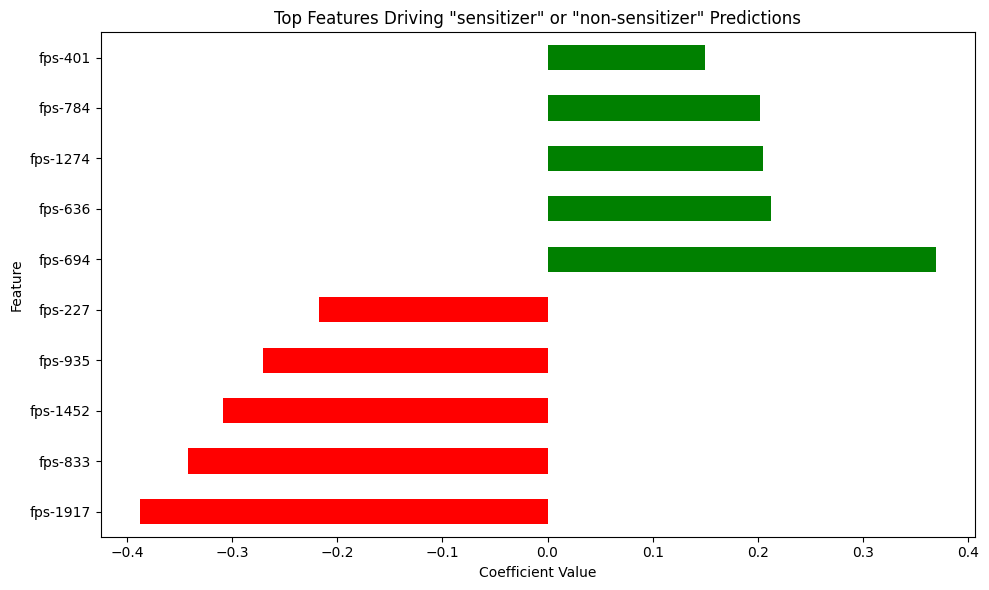

In [22]:
# Extract model from pipe
lr_model = lr.named_steps['logisticregression']
selected_features = x_train.columns[lr.named_steps['selectkbest'].get_support()]


coefficients = lr_model.coef_[0]  # shape: (n_features,)
assert len(coefficients) == len(selected_features), "Mismatch between coefficients and selected features"

feature_importance = pd.Series(coefficients, index=selected_features)

# Sort and get top 10 positive and negative features
top_positive = feature_importance.sort_values(ascending=False).head(5)
top_negative = feature_importance.sort_values().head(5)

# Combine for visualization
top_features = pd.concat([top_negative, top_positive])
plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color=['red' if c < 0 else 'green' for c in top_features])
plt.title('Top Features Driving "sensitizer" or "non-sensitizer" Predictions')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

**🧮 lr Confusion Matrix**

Logistic Regression model performs well overall on the test set, with 14 out of 41 predictions misclassified. However, it struggles more with the non-sensitizer class (0), exhibiting 14 false positives while having zero false negatives for the sensitizer class (1).  This suggests a potential bias towards predicting the positive class.

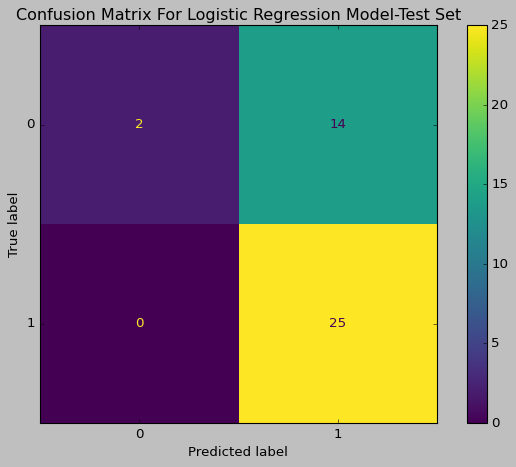

In [23]:
plot_metric(lr, x_test, y_test, "Logistic Regression Model-Test Set", show_mat=True, show_roc=False)

**lr ROC Curve Insights** 

The curve plots the true positive Rate `(TPR)` against the False Positive Rate `(FPR)`,  shows moderate model performance with an AUC of 0.75, indicating it's better than random gussing but could be improved.

The jagged, stair-step shape suggests the model's predicted probabilities are not well-calibrated.This means model's confidence scores may not accurately reflect the true likelihood.

**E.g.** When the model says "I'm 60% confident this is a positive result", in reality (when it gives that 0.6 prediction), the actual outcome is positive more or less often than 60% of the time. 

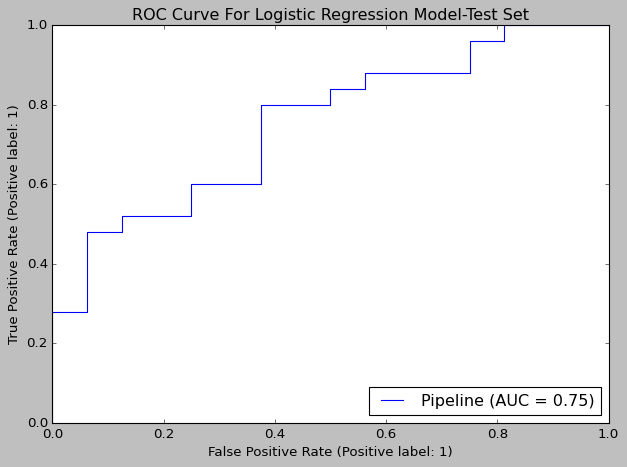

In [24]:
plot_metric(lr, x_test, y_test, "Logistic Regression Model-Test Set", show_mat=False, show_roc=True)

#### 2. SVC (Support Vector Classifier)

Next, I will switch to a SVC since logistic regression didn't perform well. SVC is a bit more complex, offers non-linear decision boundaries and high-dimensional data.

First, an untuned `SVC` model to:
- Set a performance floor.
- Measure how much later tuning improves results.

Model is trained on the training data, and its performance is evaluated on both the training and validation sets.

In [25]:
from sklearn.svm import SVC


svc_clf = make_pipeline(SVC(probability=True, random_state=42))

svc_clf.fit(x_train, y_train)

y_train_pred = svc_clf.predict(x_train)
y_train_proba = svc_clf.predict_proba(x_train)[:, 1]

y_pred = svc_clf.predict(x_valid)
y_proba = svc_clf.predict_proba(x_valid)[:, 1]

print_scores(y_train, y_train_pred, y_train_proba, "Training")
print_scores(y_valid, y_pred, y_proba, "Validation")


_________________________________________
Training accuracy: 92.26%
Training Precision: 90.40%
Training Recall: 99.56%
Training F1 Score: 94.76%
Training ROC AUC: 99.50%
_________________________________________
Validation accuracy: 62.50%
Validation Precision: 60.00%
Validation Recall: 95.45%
Validation F1 Score: 73.68%
Validation ROC AUC: 74.75%


### 🔧 Model Tuning Setup (Used Repeatedly)

The next cell is a repeated workflow used throughout this notebook to manually tune and evaluate different models. 
It includes: 

- **Stratified 10-Fold Cross-Validation** to ensure balanced class distribution in each fold.
- **Manual hyperparameter tuning** by adjusting the model parameters directly in the code.
- **Brute-force Grid Search (externally run)** on Google Colab with an extended range of hyperparameters, used at certain points to guide manual tuning.
- **Feature selection** using `SelectKBest` to reduce dimensionality before fitting the model.
- **Custom scoring metrics** such as accuracy, ROC_AUC, precision, and recall, evaluated using cross-validation. For each metric, the **average and standard deviation across folds** are printed for both training and test folds. 


This setup helped me to understand the generalization and the overfitting behavior of each model.

In [26]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
# Recommended SVC parameters with feature selection
svc_clf = make_pipeline(SelectKBest(f_classif, k=1550), SVC(
        probability=True,
        C= 0.32,
        # kernel='',
        max_iter=23,
        random_state=42
    )
)

pipeline = make_pipeline(svc_clf)
cv = StratifiedKFold(n_splits=10)
# Custom scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score), 'percision': make_scorer(precision_score),'recall': make_scorer(recall_score)}
# Run CV
scores = cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
print("Cross-validation results:")
# printing scores
for key in scores:
    if key.startswith("test_"):
        label = f"* {key}"
        print(f"{label}: {scores[key].mean():.4f} ± {scores[key].std():.4f}")
for key in scores:
    if key.startswith("train_"):
        print(f"{key}: {scores[key].mean():.4f} ± {scores[key].std():.4f}")

Cross-validation results:
* test_accuracy: 0.6908 ± 0.0565
* test_roc_auc: 0.5728 ± 0.1058
* test_percision: 0.7494 ± 0.0734
* test_recall: 0.8678 ± 0.1061
train_accuracy: 0.7984 ± 0.0215
train_roc_auc: 0.7224 ± 0.0293
train_percision: 0.8232 ± 0.0210
train_recall: 0.9100 ± 0.0414


**SVC with Optimized Hyperparameters**

I train and evaluate the model using the best-performing parameters found during tuning. The pipeline includes feature selection using `SelectKBest` with `f_classif`, selecting the top 1550 features, followed by an SVM classifier (`SVC`) with the following settings: 

- `C = 0.32`: Controls the trade-off between margin size and classification accuracy. Lower values allow a softer margin, helping to avoid overfitting.
- `max_iter = 23`: Limits iterations the optimizer runs. Helps reduce training time and can act as a form of early stopping. 
- `random_state = 42`: fixing the model's randomness for reproducability. 
- `probability = True`: Enables probability predictions (instead of just class labels), required by `roc_auc_score` function to calculate ROC

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif

# Recommended SVC parameters with feature selection
svc_clf = make_pipeline(SelectKBest(f_classif, k=1550), SVC(
        probability=True,
        C= 0.32,
        # kernel='',
        max_iter=23,
        random_state=42
    )
)
svc_clf.fit(x_train, y_train)

y_train_pred = svc_clf.predict(x_train)
y_train_proba = svc_clf.predict_proba(x_train)[:, 1]

y_pred = svc_clf.predict(x_valid)
y_proba = svc_clf.predict_proba(x_valid)[:, 1]

# Modify y_proba in place by setting values below the threshold to 0 (or another value)

print_scores(y_train, y_train_pred, y_train_proba, "Training")
print_scores(y_valid, y_pred, y_proba, "Validation")

_________________________________________
Training accuracy: 79.88%
Training Precision: 81.89%
Training Recall: 91.63%
Training F1 Score: 86.49%
Training ROC AUC: 85.04%
_________________________________________
Validation accuracy: 70.00%
Validation Precision: 69.23%
Validation Recall: 81.82%
Validation F1 Score: 75.00%
Validation ROC AUC: 79.29%


**📊 Evaluating the Optimized SVC Model on the Test Set**

I evaluate optimized model performance on test set to assess generalization to unseen data.

The following metrics were calculated:
- **Accuracy**: 73.17%  
  Indicates the percentage of correct predictions out of all test examples.
- **Precision**: 73.33%  
 Higher precision reduces false positives.
- **Recall**: 88.00%  
  Higher recall reduces false negatives.
- **F1 Score**: 80.00%  
  Harmonic mean of precision and recall. A balanced metric when both false positives and false negatives matter.
- **ROC AUC**: 80.75%  
  Evaluates model's ability to distinguish between classes across all thresholds. AUC close to 1.0 indicates strong separability.

Results suggest that the optimized SVC model performs well, particularly in maintaining a good balance of overall performance across metrics.

In [28]:
y_test_pred = svc_clf.predict(x_test).astype(int)
y_test_proba = svc_clf.predict_proba(x_test)[:, 1]


print("Evaluating SVC on test set:")
print_scores(y_test, y_test_pred, y_test_proba, "Test")

Evaluating SVC on test set:
_________________________________________
Test accuracy: 73.17%
Test Precision: 73.33%
Test Recall: 88.00%
Test F1 Score: 80.00%
Test ROC AUC: 80.75%


#### ** lr Feature Importance**


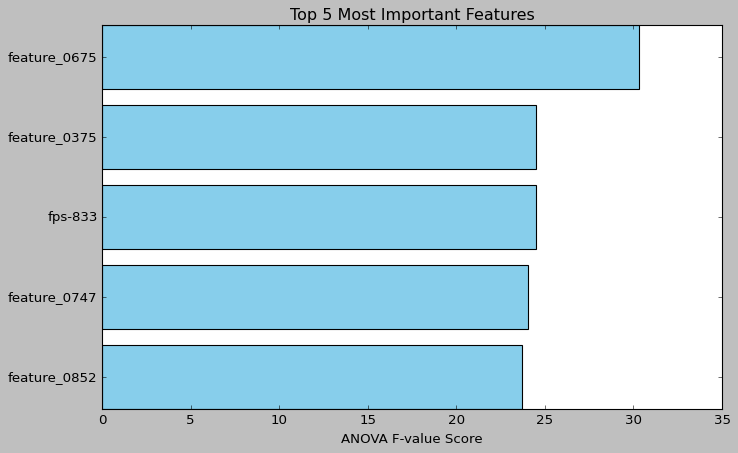

In [30]:
# Get the SelectKBest step from the pipeline.
selector = svc_clf.named_steps['selectkbest']

# Get the feature score.
feature_scores = selector.scores_
# feature_pvalues = selector.pvalues_  # You could also look at p-values if interested

# Get the feature names.
if hasattr(x_train, 'columns'):
    feature_names = x_train.columns
else:
    feature_names = np.arange(x_train.shape[1])

# Get the indices of the features (top k=1550)
selected_indices = selector.get_support(indices=True)

# Get the scores and names of selected features
selected_scores = feature_scores[selected_indices]
selected_names = feature_names[selected_indices]

# Sort the selected features by score and get top 5.]
top5_indices = np.argsort(selected_scores)[-5:][::-1]
top5_scores = selected_scores[top5_indices]
top5_names = selected_names[top5_indices]

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(top5_names, top5_scores, color='skyblue')
plt.xlabel('ANOVA F-value Score')
plt.title('Top 5 Most Important Features')
plt.gca().invert_yaxis()  # Highest score at top
plt.show()

**🧮 Visualizing SVC Classification Results**

To further interpret the SVC model's performance, I plotted a confusion matrix to illustrate how well the model distinguishes between the two classes, showing overall accuracy and the distribution of predictions. 

In the matrix:
- The **top-left (8)** represents **true negatives**: correctly predicted class 0.
- The **bottom-right (22)** shows **true positives**: correctly predicted class 1.
- The **top-right (8)** are **false positives**: class 0 incorrectly predicted as class 1.
- The **bottom-left (3)** are **false negatives**: class 1 incorrectly predicted as class 0.

Imbalanced data in favor of class 1 (Sensitizers) makes high recall expected. This matrix confirms capturing most positives, though it misclassifies some negatives, highlighting a trade-off in precision.

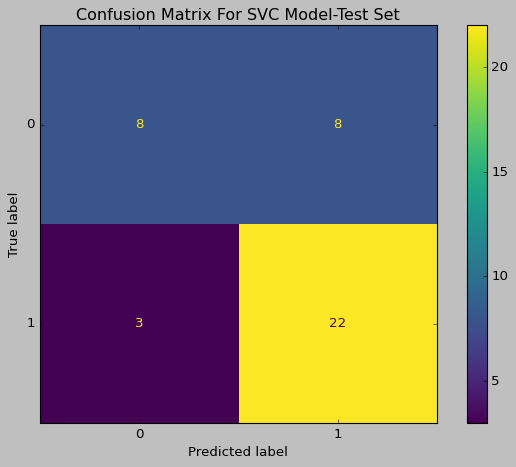

In [31]:
plot_metric(svc_clf, x_test, y_test, "SVC Model-Test Set", show_mat=True, show_roc=False)

**SVC ROC Curve**

The ROC curve below visualizes my SVC's ability to distinguish between classes (**"1" vs "0"**) at different classification thresholds.

- **(AUC = 0.81)** => Better than most baseline models:

  - Curves sharply toward the top-left → Strong separability  
  - **Practical meaning**: 81% chance model ranks a random positive instance higher than a random negative one.

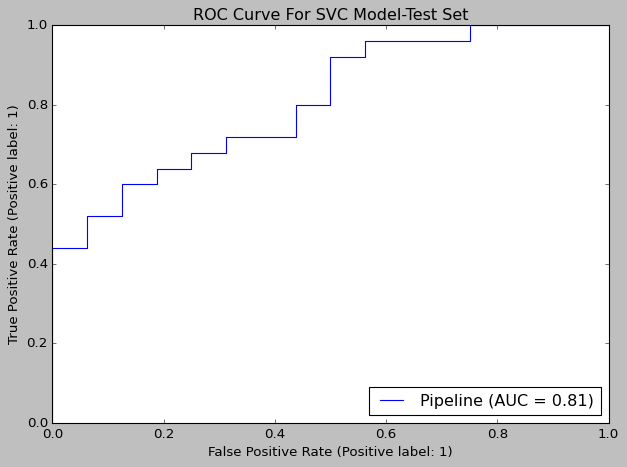

In [32]:
plot_metric(svc_clf, x_test, y_test, "SVC Model-Test Set", show_mat=False, show_roc=True)

In [ ]:
# This is just garpage ignore it
import numpy as np
from sklearn.metrics import make_scorer
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore", category=ConvergenceWarning)


def mean_perc_roc_auc(y_true, y_pred_proba):
    y_pred = (y_pred_proba >= 0.5).astype(int)  # turn probs into 0/1 labels
    perc = precision_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    accuracy = accuracy_score(y_true, y_pred)
    return (perc + auc + accuracy) / 3

# Tell make_scorer that our function needs the predicted probabilities
scorer = make_scorer(mean_perc_roc_auc, needs_proba=True)


# Create the pipeline
pipeline = make_pipeline(
    SVC(probability=True, random_state=42, C=1.6,kernel = 'rbf', gamma=0.032) 
    )

param_grid = {
    'svc__max_iter': np.random.randint(20, 70, 10),
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Set up GridSearchCV with the pipeline
grid_search = GridSearchCV(
    estimator=pipeline,       # your model pipeline
    param_grid=param_grid,    # the params to test
    scoring=scorer,
    n_jobs=-1,           # our custom scoring function
    cv=cv,                  # cross-validation folds
    return_train_score= True
)



grid_search.fit(x_train, y_train)
y_pred = grid_search.predict(x_valid)
y_proba = grid_search.predict_proba(x_valid)[:, 1]
print_scores(y_valid, y_pred, y_proba, "Validation")

## Random Forest (RF)

After tried both Logistic Regression and Support Vector Classifier, I turned to a tree-based ensemble model: **Random Forest**. As the saying goes, _"two heads are better than one"_—and Random Forest takes that to the next level with **n_estimators** working together.

Unlike LR and SVC, RFs capture **complex relationships** without manual feature engineering or choosing kernels.it's **less sensitive to noise and outliers**.

strengths of Random Forest:
- **Handles high-dimensional input** effectively.
- Doesn’t assume linearity (unlike LR or SVC).
- Automatically selects informative features via **feature bagging**.
- Requires **minimal preprocessing** or heavy data **scaling** or transformations.
- Well-suited for datasets like mine, which include a wide range of **SMILES lengths** (4–98, std dev ≈ 15.9), which can destabilize strong models.


In [35]:
from sklearn.ensemble import RandomForestClassifier

# Create the XGBoost model with desired params
model = RandomForestClassifier(random_state=42) # min_samples_leaf=2

# Fit model
model.fit(x_train, y_train)

# Predictions
y_train_pred = model.predict(x_train)
y_train_proba = model.predict_proba(x_train)[:, 1]

y_pred = model.predict(x_valid)
y_proba = model.predict_proba(x_valid)[:, 1]



# Evaluate
print_scores(y_train, y_train_pred, y_train_proba, "Training")
print_scores(y_valid, y_pred, y_proba, "Validation")

_________________________________________
Training accuracy: 100.00%
Training Precision: 100.00%
Training Recall: 100.00%
Training F1 Score: 100.00%
Training ROC AUC: 100.00%
_________________________________________
Validation accuracy: 62.50%
Validation Precision: 61.29%
Validation Recall: 86.36%
Validation F1 Score: 71.70%
Validation ROC AUC: 61.11%


### 🔧 Model Tuning Setup (Used Repeatedly)

The next cell is a repeated workflow used throughout this notebook to manually tune and evaluate different models. 
It includes: 

- **Stratified 10-Fold Cross-Validation** to ensure balanced class distribution in each fold.
- **Manual hyperparameter tuning** by adjusting the model parameters directly in the code.
- **Brute-force Grid Search (externally run)** on Google Colab with an extended range of hyperparameters, used at certain points to guide manual tuning.
- **Feature selection** using `SelectKBest` to reduce dimensionality before fitting the model.
- **Custom scoring metrics** such as accuracy, ROC_AUC, precision, and recall, evaluated using cross-validation. For each metric, the **average and standard deviation across folds** are printed for both training and test folds. 


This setup helped me to understand the generalization and the overfitting behavior of each model.

In [36]:
from sklearn.model_selection import StratifiedKFold, cross_validate

# Define the model
rf_clf = RandomForestClassifier(
     criterion='gini', n_estimators=16, max_depth=12,random_state=42,
    #   min_impurity_decrease=0.00002, 
    #  min_impurity_decrease=1
)

rf_clf = RandomForestClassifier(
     criterion='gini', n_estimators=20, max_depth=16,random_state=42,min_impurity_decrease=0.0002
)

rf_clf = RandomForestClassifier(
     criterion='gini', n_estimators=17, max_depth=12,random_state=42,
)

# Define the model
rf_clf = RandomForestClassifier(
     criterion='gini', n_estimators=16, max_depth=12,random_state=42,
    #   min_impurity_decrease=0.00002, 
    #  min_impurity_decrease=1
)
# If no preprocessing, you can skip `make_pipeline` and use model directly.
pipeline = make_pipeline(rf_clf)

# Set up Stratified K-Fold
# cv = StratifiedKFold(n_splits=10)
cv = StratifiedKFold(n_splits=50)

# Custom scoring metrics
scoring = {'accuracy': make_scorer(accuracy_score), 'roc_auc': make_scorer(roc_auc_score), 'percision': make_scorer(precision_score),'recall': make_scorer(recall_score)}
# Run CV
scores = cross_validate(pipeline, x_train, y_train, cv=cv, scoring=scoring, return_train_score=True)
print("Cross-validation results:")
# printing scores
for key in scores:
    if key.startswith("test_"):
        label = f"* {key}"
        print(f"{label}: {scores[key].mean():.4f} ± {scores[key].std():.4f}")
for key in scores:
    if key.startswith("train_"):
        print(f"{key}: {scores[key].mean():.4f} ± {scores[key].std():.4f}")

Cross-validation results:
* test_accuracy: 0.7510 ± 0.1569
* test_roc_auc: 0.6455 ± 0.2012
* test_percision: 0.7909 ± 0.1308
* test_recall: 0.9010 ± 0.1605
train_accuracy: 0.9917 ± 0.0038
train_roc_auc: 0.9874 ± 0.0056
train_percision: 0.9902 ± 0.0045
train_recall: 0.9981 ± 0.0029


**RF with Optimized Hyperparameters**

After testing various combinations of parameters, I found that the following configuration gave the best performance for my dataset:

- `criterion = 'gini'`: Uses Gini impurity measure to evaluate splits. It's computationally efficient and typically performs well for classification tasks.
- `n_estimators = 16`: A relatively small number of trees to reduce training time and overfitting while still benefiting from ensemble averaging to lower variance.
- `max_depth = 12`: Limits how deep each tree can grow, helping to prevent overfitting and encouraging generalization by restricting overly complex patterns.
- `random_state = 42`: Ensures reproducibility of results by controlling the randomness in bootstrapping and feature selection.

This setup balances complexity and generalization while keeping the model deep enough to capture patterns in the data without overfitting

In [37]:
# Define the model
rf_clf = RandomForestClassifier(
     criterion='gini', n_estimators=16, max_depth=12,random_state=42,
    #   min_impurity_decrease=0.00002, 
    #  min_impurity_decrease=1
)

# Fit model
rf_clf.fit(x_train, y_train)

# Predictions
y_train_pred = rf_clf.predict(x_train)
y_train_proba = rf_clf.predict_proba(x_train)[:, 1]

y_pred = rf_clf.predict(x_valid)
y_proba = rf_clf.predict_proba(x_valid)[:, 1]



# Evaluate
print_scores(y_train, y_train_pred, y_train_proba, "Training")
print_scores(y_valid, y_pred, y_proba, "Validation")


_________________________________________
Training accuracy: 99.69%
Training Precision: 99.56%
Training Recall: 100.00%
Training F1 Score: 99.78%
Training ROC AUC: 100.00%
_________________________________________
Validation accuracy: 70.00%
Validation Precision: 69.23%
Validation Recall: 81.82%
Validation F1 Score: 75.00%
Validation ROC AUC: 75.00%


In [38]:
# our valid set looks like it isn't representive of our whole data set at all!!
y_valid.value_counts(normalize=True)

Y
1    0.55
0    0.45
Name: proportion, dtype: float64

### 🏅**📊 Evaluating RF model on the Test Set (Top Model)** 

After  tuning, the Random Forest model shows promising improvements over our baseline SVC. Let's evaluate its performance on the test set.

#### 📊 ** Test Set Metrics**
- **Accuracy**: 75.6% — indicates the overall proportion of correct predictions.
- **Precision**: 77.8% — reflects that nearly 78% of positive predictions were correct.
- **Recall**: 84% — shows the model successfully identified 84% of all actual positives.
- **F1 Score**: 80.8% — the harmonic mean of precision and recall, balancing both aspects.

- It maintained a better balance across all metrics 
- It achieved higher precision without sacrificing too much recall.

*advantages*:  
✓ Better overall accuracy  
✓ Improved precision-recall balance  
✓ More consistent performance across metrics

In [39]:
#  Evaluate on test set
y_test_pred = rf_clf.predict(x_test)
y_test_proba = rf_clf.predict_proba(x_test)[:, 1]

print("Evaluating on test set:")
print_scores(y_test, y_test_pred, y_test_proba, "Test")

Evaluating on test set:
_________________________________________
Test accuracy: 75.61%
Test Precision: 77.78%
Test Recall: 84.00%
Test F1 Score: 80.77%
Test ROC AUC: 76.00%


#### **Random Forest: Confusion Matrix (Test Set)**

- **Strong specificity**: Correctly predicted **21 sensitizers** (true positives, class `0`), but missed **6** (false positives).  
- **High recall for non-sensitizers**: Captured **10 true negatives** (class `0`), with only **4 false negatives**, aligning with the high recall (84%) observed earlier.  
- **Precision trade-off**: While recall is robust, the **6 false positives** (class `0` predicted as `1`) explain the precision score of 77.

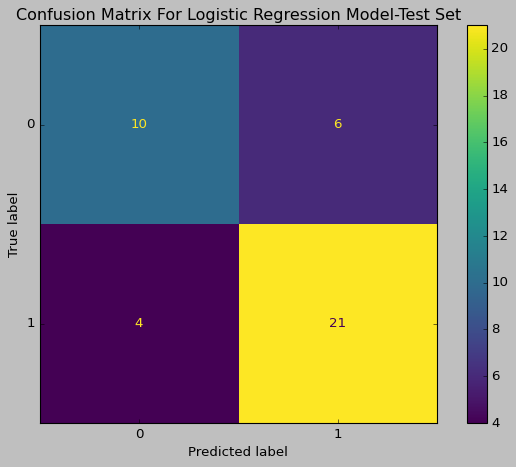

In [40]:
plot_metric(rf_clf, x_test, y_test, "Logistic Regression Model-Test Set", show_mat=True, show_roc=False)

**🔍RF ROC Curve Analysis**

- **ROC (Receiver Operating Characteristic)** visualizes the performance of RF classifier by plotting **True Positive Rate (Recall)** against the **False Positive Rate** at various threshold settings.

- **AUC (Area Under Curve)** is **0.76**, indicating that the model has a **76% chance of correctly distinguishing between the positive and negative classes**.

- The model **leans slightly toward recall**, meaning it's favoring capturing as many positives as possible, which is expected given the imbalanced nature of our data.

- Given the **balance between precision and recall**, and a solid ROC AUC, the Random Forest model demonstrates **strong and balanced performance**.

- **ROC curve shape** arcs toward the top-left corner, reinforces that the classifier is **making well-calibrated decisions across thresholds**.

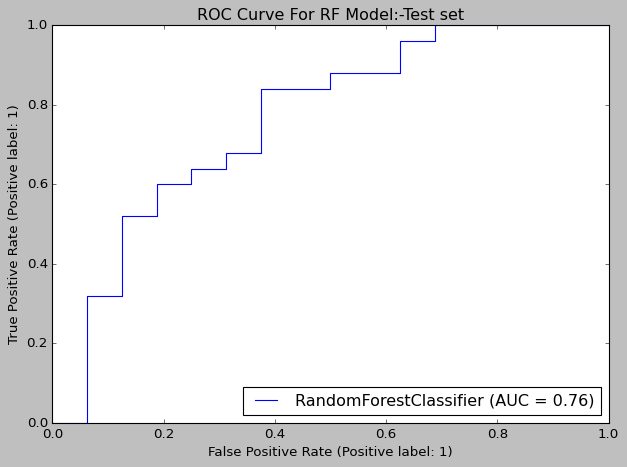

In [41]:
plot_metric(rf_clf, x_test, y_test, "RF Model:-Test set", show_mat=False, show_roc=True)

### Generally, Feature Importance Isn't Interpretable Here

Observing feature importance scores. They aren't directly interpretable in this context since we can't know what feature 4243 actually represents. 

**However, we can note an interesting pattern:** as we use more non-linear models, we begin to see greater importance being assigned to those non-linear `float`-type features generated by our compound embeddings featurizer!

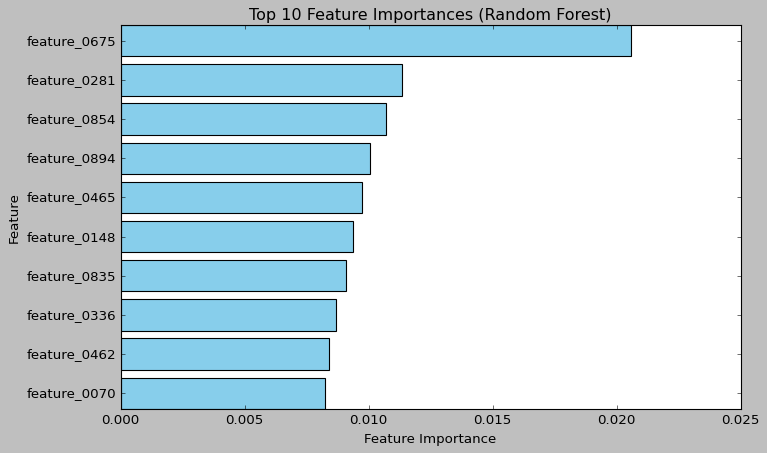

In [42]:
import pandas as pd
# Extract feature importances from the trained Random Forest model
feature_importances = rf_clf.feature_importances_

feature_names = x_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
})

# Sort the features by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(importance_df["Feature"].head(10), importance_df["Importance"].head(10), color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()